# Making line plots

### Import packages

In [1]:
import numpy                          as np
import matplotlib.pyplot              as plt
import matplotlib.animation           as ani
import IPython

# import plons scripts
import plons.LoadData                 as load
import plons.SmoothingKernelScript    as sk
import plons.PhysicalQuantities       as pq
import plons.ConversionFactors_cgs    as cgs

### Setting information about data

In [2]:
prefix = "wind"
loc = "/STER/matse/Papers/Esseldeurs+2023/Phantom/High/binary6Lucy/"
outputloc = "."
phantom_dir = "/home/matse/codes/phantom/"
dump = loc+"wind_00600"

### Loading setup and dump

In [3]:
setup     = load.LoadSetup(loc, prefix)

In [4]:
dumpData  = load.LoadDump_cgs(dump, setup, phantom_dir)

### Making x and z lines on which to smooth

In [5]:
n = 200
rx = np.array((np.linspace(-150, 150, n), np.zeros(n), np.zeros(n))).transpose()*cgs.au
theta = pq.getPolarAngleCompanion(dumpData['posComp'][0], dumpData['posComp'][1])
rz = np.array((np.zeros(n), np.zeros(n), np.linspace(-150, 150, n))).transpose()*cgs.au

### Smoothing the data on the lines

In [6]:
smoothx = sk.getSmoothingKernelledPix(100, dumpData, ['rho'], sk.rotatePixCoordAroundZ(theta, rx))
smoothz = sk.getSmoothingKernelledPix(100, dumpData, ['rho'], rz)

### Plotting the lines

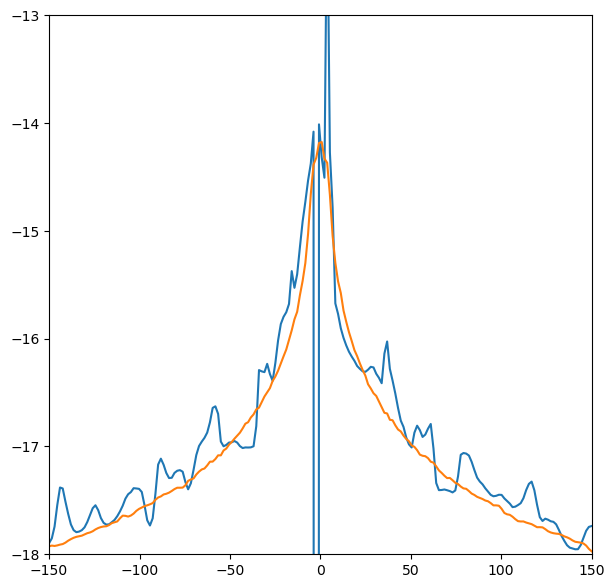

In [7]:
fig, ax = plt.subplots(1, figsize=(7, 7))

ax.plot(rx[:,0]/cgs.au, np.log10(smoothx["rho"]+1e-99))
ax.plot(rz[:,2]/cgs.au, np.log10(smoothz["rho"]+1e-99))
ax.set_xlim(-150, 150)
ax.set_ylim(-18, -13)

plt.show()

## Animation

In [8]:
n = 200
x = np.linspace(-30*cgs.au, 30*cgs.au, n)
y = np.linspace(-30*cgs.au, 30*cgs.au, n)
X, Y = np.meshgrid(x, y)
Z    = np.zeros_like(X)
X_rot, Y_rot, Z_rot = sk.rotateMeshAroundZ(theta, X, Y, Z)
smooth_rot = sk.smoothMesh(X_rot, Y_rot, Z_rot, dumpData, ['rho'])

In [9]:
fig = plt.figure(figsize=(14, 7))

ax = [None, None]
ax[0] = plt.subplot2grid((1, 2), (0, 0))
ax[1] = plt.subplot2grid((1, 2), (0, 1), aspect=ax[0].get_aspect())

ax[0].set_aspect('equal')
ax[0].set_facecolor('k')

ax[0].pcolormesh(X/cgs.au, Y/cgs.au, np.log10(smooth_rot["rho"]+1e-99), cmap=plt.cm.get_cmap('inferno'), vmin=-17, vmax = -14)
ax[0].set_xlim(x[0]/cgs.au, x[-1]/cgs.au)
ax[0].set_ylim(y[0]/cgs.au, y[-1]/cgs.au)

circleAGB = plt.Circle((-np.linalg.norm(dumpData['posAGB'])/cgs.au, 0.), setup["wind_inject_radius"], transform=ax[0].transData._b, color="black", zorder=10)
ax[0].add_artist(circleAGB)
circleComp = plt.Circle((np.linalg.norm(dumpData['posComp'])/cgs.au, 0.), setup["rAccrComp"], transform=ax[0].transData._b, color="black", zorder=10)
ax[0].add_artist(circleComp)

n = 200
rx0 = np.array((np.linspace(-50, 50, n), np.zeros(n), np.zeros(n))).transpose()*cgs.au
theta0 = pq.getPolarAngleCompanion(dumpData['posComp'][0], dumpData['posComp'][1])
rz = np.array((np.zeros(n), np.zeros(n), np.linspace(-50, 550, n))).transpose()*cgs.au

line0 = ax[0].plot(rx[:,0], rx[:,1], color="white")[0]

smoothx = sk.getSmoothingKernelledPix(100, dumpData, ['rho'], sk.rotatePixCoordAroundZ(theta0, rx0))
smoothz = sk.getSmoothingKernelledPix(100, dumpData, ['rho'], rz)

line1 = ax[1].plot(rx[:,0]/cgs.au, np.log10(smoothx["rho"]+1e-99))[0]
ax[1].plot(rz[:,2]/cgs.au, np.log10(smoothz["rho"]+1e-99))
ax[1].set_xlim(-50, 50)
ax[1].set_ylim(-18, -13)

posx0 = ax[0].get_position()
posx1 = ax[1].get_position()
ax[1].set_position([posx1.x0, posx0.y0, posx0.width, posx0.height])

def animate(frame):
    rx = sk.rotatePixCoordAroundZ(-frame/np.pi/50, rx0)
    smoothx = sk.getSmoothingKernelledPix(100, dumpData, ['rho'], sk.rotatePixCoordAroundZ(theta0, rx))

    line0.set_data(rx[:,0], rx[:,1])
    line1.set_data(rx0[:,0]/cgs.au, np.log10(smoothx["rho"]+1e-99))

anim = ani.FuncAnimation(fig, animate, frames=500, interval=20)
video = anim.to_html5_video()
html = IPython.display.HTML(video)
IPython.display.display(html)
plt.close()